# Train

https://mapreader.readthedocs.io/en/latest/User-guide/Train.html

In [1]:
# solve issue with autocomplete
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Read annotations

In [2]:
from mapreader import loadAnnotations

In [3]:
annotated_images = loadAnnotations()

annotated_images.load("./annotations_mnist/mnist_#kasra#.csv", 
                      path2dir="../../../mapreader/datasets/small_mnist")

* reading: ./annotations_mnist/mnist_#kasra#.csv
* #rows: 154
* label column name: label (you can change this later by .set_col_label(new_label) )
* shuffle rows: Yes
* update paths in 'image_id' column by inserting '../../../mapreader/datasets/small_mnist'

------------------------
* Number of annotations: 154

* First few rows:
                                            image_id  label
0  /Users/rwood/LwM/MapReader/mapreader/datasets/...      2
1  /Users/rwood/LwM/MapReader/mapreader/datasets/...      1
2  /Users/rwood/LwM/MapReader/mapreader/datasets/...      1
3  /Users/rwood/LwM/MapReader/mapreader/datasets/...      1
4  /Users/rwood/LwM/MapReader/mapreader/datasets/...      1
...

* Value counts (column: label):
2    80
1    74
Name: label, dtype: int64
------------------------



In [4]:
print(annotated_images)

------------------------
* Number of annotations: 154

* First few rows:
                                            image_id  label
0  /Users/rwood/LwM/MapReader/mapreader/datasets/...      2
1  /Users/rwood/LwM/MapReader/mapreader/datasets/...      1
2  /Users/rwood/LwM/MapReader/mapreader/datasets/...      1
3  /Users/rwood/LwM/MapReader/mapreader/datasets/...      1
4  /Users/rwood/LwM/MapReader/mapreader/datasets/...      1
...

* Value counts (column: label):
2    80
1    74
Name: label, dtype: int64
------------------------



In [5]:
# Shift labels so that they start from 0
annotated_images.adjust_labels(shiftby=-1)

--------------------
[INFO] value counts before shift:
2    80
1    74
Name: label, dtype: int64
--------------------
[INFO] value counts after shift:
1    80
0    74
Name: label, dtype: int64
--------------------


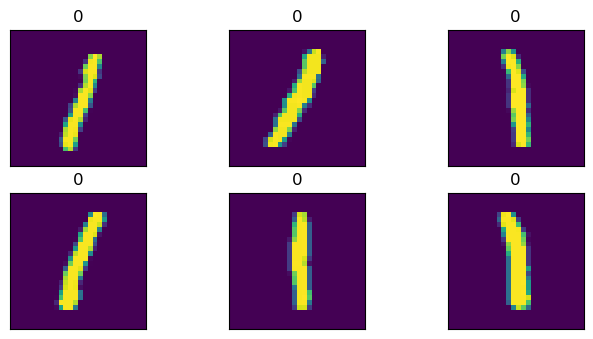

In [6]:
# show sample images for target label (tar_label)
annotated_images.show_image_labels(tar_label=0, num_sample=6)

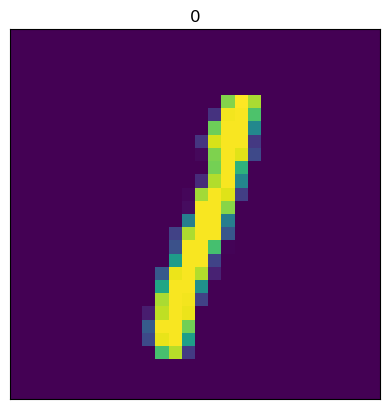

In [7]:
# show an image based on its index 
annotated_images.show_image(indx=1)

### Split annotations train/val


In [8]:
annotated_images.split_annotations(frac_train=0.8, 
                                   frac_val=0.2, 
                                   frac_test=0.0)

---------------------
* Split dataset into:
    Train: 123
    Valid: 31
    Test : 0
---------------------


In [9]:
annotated_images.train["label"].value_counts()

1    64
0    59
Name: label, dtype: int64

In [10]:
annotated_images.val["label"].value_counts()

1    16
0    15
Name: label, dtype: int64

## Prepare datasets

In [11]:
import numpy as np
from torchvision import transforms
from mapreader import patchTorchDataset
import torch

In [12]:
resize = 224

normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([transforms.Resize(resize), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(normalize_mean,normalize_std)])



In [13]:
train_dataset = patchTorchDataset(annotated_images.train, 
                                  transform=data_transforms)
val_dataset = patchTorchDataset(annotated_images.val,   
                                  transform=data_transforms)


In [14]:
train_count_list=train_dataset.patchframe["label"].value_counts().to_list()
val_count_list=val_dataset.patchframe["label"].value_counts().to_list()

weights = np.reciprocal(torch.Tensor(train_count_list))
weights = weights.double()

train_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights[train_dataset.patchframe["label"].to_list()], 
    num_samples=len(train_dataset))

val_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights[val_dataset.patchframe["label"].to_list()], 
    num_samples=len(val_dataset))


## Set up `classifier`

In [15]:
from mapreader import classifier

In [16]:
my_classifier = classifier()

[INFO] Device is set to cpu


In [18]:
batch_size = 8

# Add training dataset
my_classifier.add2dataloader(train_dataset, 
                            set_name="train", 
                            batch_size=batch_size, 
                            shuffle=False,
                            sampler=train_sampler
                           )

# Add validation dataset
my_classifier.add2dataloader(val_dataset, 
                            set_name="val", 
                            batch_size=batch_size, 
                            shuffle=False, 
                            #sampler=val_sampler
                           )

[INFO] added 'train' dataloader with 123 elements.
[INFO] added 'val' dataloader with 31 elements.


In [19]:
my_classifier.dataset_sizes

{'train': 123, 'val': 31}

In [20]:
# set class names for plots
class_names = {0: "1", 1: "3"}
my_classifier.set_classnames(class_names)

In [21]:
my_classifier.print_classes_dl()

[INFO] labels:      [0, 1]
[INFO] class-names: {0: '1', 1: '3'}


### Load a (pretrained) PyTorch model

In [22]:
my_classifier.initialize_model("resnet18")
my_classifier.model_summary()

[INFO] labels:      [0, 1]
[INFO] class-names: {0: '1', 1: '3'}
------------------------------------------------------------------------------------------
|                                  modules |           parameters |                  dim
------------------------------------------------------------------------------------------
|                             conv1.weight |                 9408 |        [64, 3, 7, 7] |
|                               bn1.weight |                   64 |                 [64] |
|                                 bn1.bias |                   64 |                 [64] |
|                    layer1.0.conv1.weight |                36864 |       [64, 64, 3, 3] |
|                      layer1.0.bn1.weight |                   64 |                 [64] |
|                        layer1.0.bn1.bias |                   64 |                 [64] |
|                    layer1.0.conv2.weight |                36864 |       [64, 64, 3, 3] |
|                      layer

### Set up optimisier, scheduler and criterion

In [23]:
params_to_optimise = my_classifier.layerwise_lr(min_lr=1e-4, max_lr=1e-3)

In [24]:
my_classifier.initialize_optimizer(params2optim=params_to_optimise)

In [25]:
my_classifier.initialize_scheduler()

In [26]:
criterion = torch.nn.CrossEntropyLoss()

my_classifier.add_criterion(criterion)

## Train/fine-tune a model

In [27]:
my_classifier.train_component_summary()

* Optimizer:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.00011475409836065574
    lr: 0.00011475409836065574
    maximize: False
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.0001295081967213115
    lr: 0.0001295081967213115
    maximize: False
    weight_decay: 0

Parameter Group 3
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.00014426229508196722
    lr

In [28]:
my_classifier.train(num_epochs=5, 
                   save_model_dir="./models_mnist", 
                   tensorboard_path="tboard_mnist", 
                   verbosity_level=0,
                   tmp_file_save_freq=2,
                   remove_after_load=False,
                   print_info_batch_freq=5)

2023-03-08 14:29:28 JY5FK6W3K5 [INFO] train    -- 1/5 --       8/123 (  6.5%) -- Loss: 0.828
2023-03-08 14:29:29 JY5FK6W3K5 [INFO] train    -- 1/5 --      48/123 ( 39.0%) -- Loss: 1.454
2023-03-08 14:29:30 JY5FK6W3K5 [INFO] train    -- 1/5 --      88/123 ( 71.5%) -- Loss: 0.001
2023-03-08 14:29:32 JY5FK6W3K5 [INFO] train    -- 1/5 --     123/123 (100.0%) -- Loss: 2.741
2023-03-08 14:29:32 JY5FK6W3K5 [INFO] train    -- 1/5 -- Loss: 0.268; F_macro: 90.81; R_macro: 90.93
2023-03-08 14:29:32 JY5FK6W3K5 [INFO] val      -- 1/5 --        8/31 ( 25.8%) -- Loss: 0.000
2023-03-08 14:29:32 JY5FK6W3K5 [INFO] val      -- 1/5 -- Loss: 0.060; F_macro: 96.76; R_macro: 96.67

2023-03-08 14:29:32 JY5FK6W3K5 [INFO] train    -- 2/5 --       8/123 (  6.5%) -- Loss: 0.008
2023-03-08 14:29:33 JY5FK6W3K5 [INFO] train    -- 2/5 --      48/123 ( 39.0%) -- Loss: 0.008
2023-03-08 14:29:35 JY5FK6W3K5 [INFO] train    -- 2/5 --      88/123 ( 71.5%) -- Loss: 0.003
2023-03-08 14:29:36 JY5FK6W3K5 [INFO] train    -- 2/5

In [29]:
list(my_classifier.metrics.keys())

['epoch_loss_train',
 'epoch_prec_micro_train',
 'epoch_recall_micro_train',
 'epoch_fscore_micro_train',
 'epoch_supp_micro_train',
 'epoch_rocauc_micro_train',
 'epoch_prec_macro_train',
 'epoch_recall_macro_train',
 'epoch_fscore_macro_train',
 'epoch_supp_macro_train',
 'epoch_rocauc_macro_train',
 'epoch_prec_weighted_train',
 'epoch_recall_weighted_train',
 'epoch_fscore_weighted_train',
 'epoch_supp_weighted_train',
 'epoch_rocauc_weighted_train',
 'epoch_prec_0_train',
 'epoch_recall_0_train',
 'epoch_fscore_0_train',
 'epoch_supp_0_train',
 'epoch_prec_1_train',
 'epoch_recall_1_train',
 'epoch_fscore_1_train',
 'epoch_supp_1_train',
 'epoch_loss_val',
 'epoch_prec_micro_val',
 'epoch_recall_micro_val',
 'epoch_fscore_micro_val',
 'epoch_supp_micro_val',
 'epoch_rocauc_micro_val',
 'epoch_prec_macro_val',
 'epoch_recall_macro_val',
 'epoch_fscore_macro_val',
 'epoch_supp_macro_val',
 'epoch_rocauc_macro_val',
 'epoch_prec_weighted_val',
 'epoch_recall_weighted_val',
 'epoch_fs

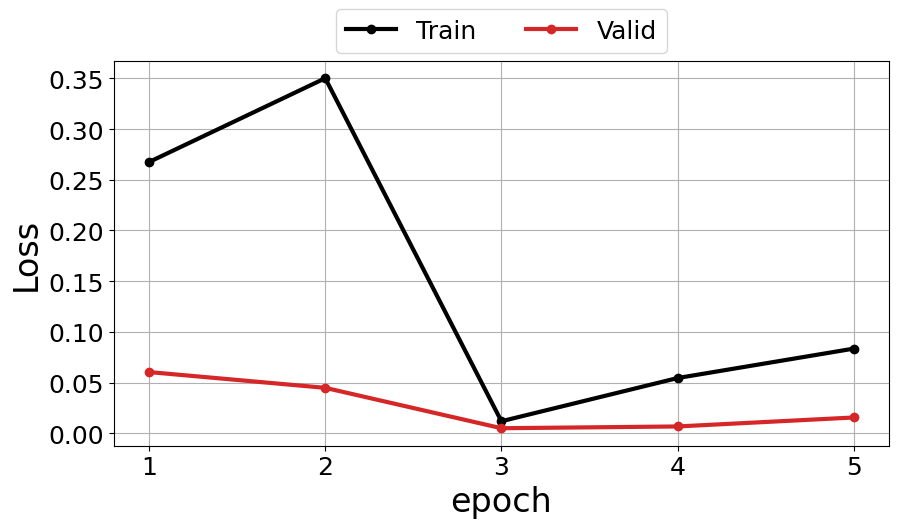

In [30]:
my_classifier.plot_metric(y_axis=["epoch_loss_train", "epoch_loss_val"],
                         y_label="Loss",
                         legends=["Train", "Valid"],
                         colors=["k", "tab:red"])

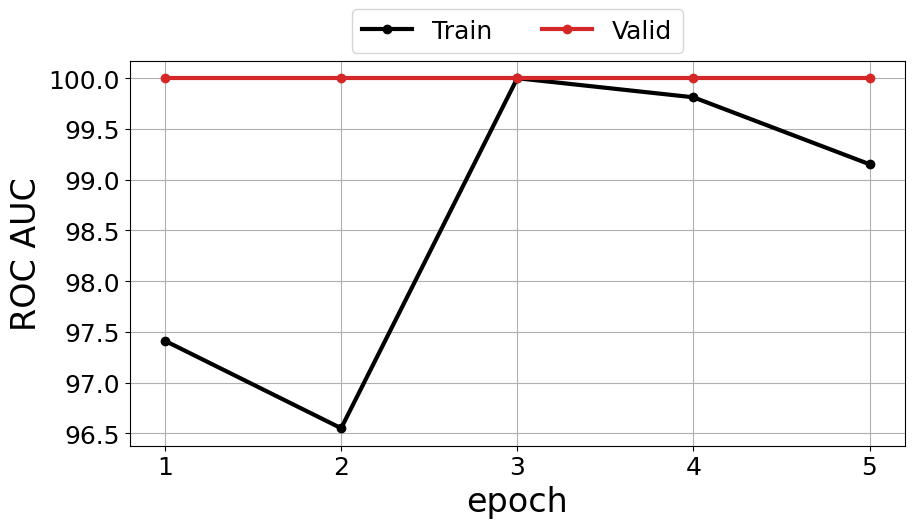

In [31]:
my_classifier.plot_metric(y_axis=["epoch_rocauc_macro_train", "epoch_rocauc_macro_val"],
                         y_label="ROC AUC",
                         legends=["Train", "Valid"],
                         colors=["k", "tab:red"])

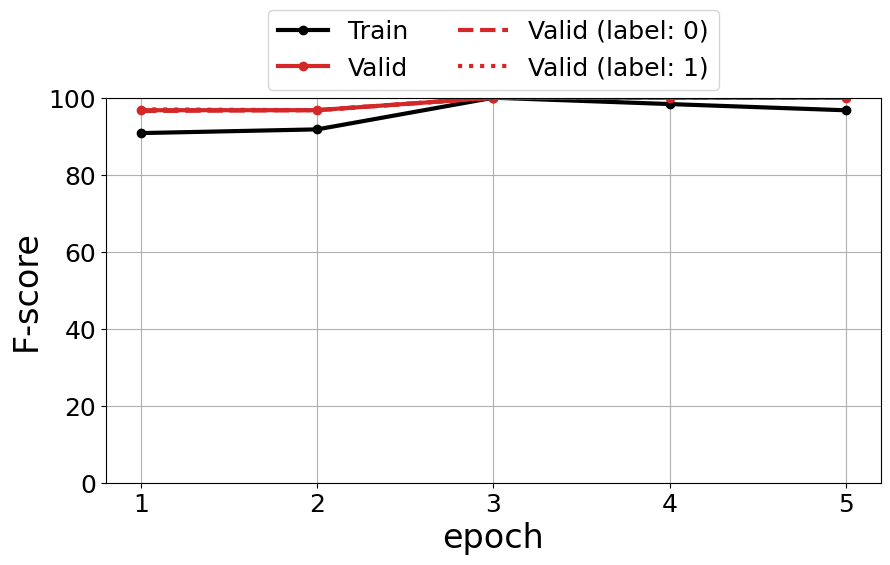

In [32]:
my_classifier.plot_metric(y_axis=["epoch_fscore_macro_train", 
                                 "epoch_fscore_macro_val", 
                                 "epoch_fscore_0_val", 
                                 "epoch_fscore_1_val"],
                         y_label="F-score",
                         legends=["Train", 
                                  "Valid", 
                                  "Valid (label: 0)",
                                  "Valid (label: 1)",],
                         colors=["k", "tab:red", "tab:red", "tab:red"],
                         styles=["-", "-", "--", ":"],
                         markers=["o", "o", "", ""],
                         plt_yrange=[0, 100])

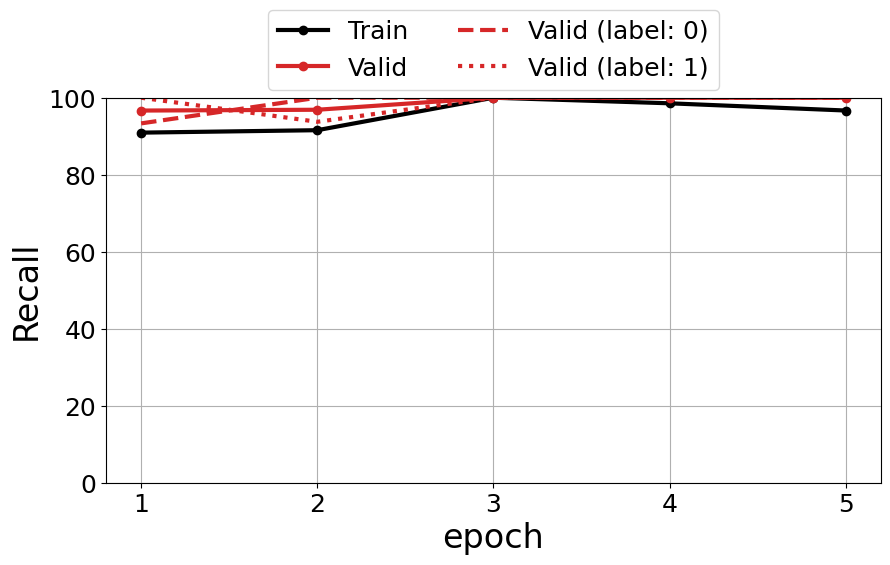

In [33]:
my_classifier.plot_metric(y_axis=["epoch_recall_macro_train", 
                                 "epoch_recall_macro_val", 
                                 "epoch_recall_0_val", 
                                 "epoch_recall_1_val"],
                         y_label="Recall",
                         legends=["Train", 
                                  "Valid", 
                                  "Valid (label: 0)",
                                  "Valid (label: 1)",],
                         colors=["k", "tab:red", "tab:red", "tab:red"],
                         styles=["-", "-", "--", ":"],
                         markers=["o", "o", "", ""],
                         plt_yrange=[0, 100])